In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import Adam


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Set random seed for reproducibility
torch.manual_seed(44)
np.random.seed(44)



class VanGenuchten:
    def __init__(self, theta_s, theta_r, alpha, n, Ks, l):
        self.theta_s, self.theta_r = theta_s, theta_r
        self.alpha, self.n, self.m = alpha, n, 1.0 - 1.0/n
        self.Ks, self.l = Ks, l
        self._tiny = 1e-12  # minimal guard

    def theta(self, h):
        abs_h = torch.abs(h)
        denom = (1.0 + (self.alpha * abs_h).pow(self.n)).pow(self.m)
        denom = denom + self._tiny                      # avoid 0
        theta_unsat = self.theta_r + (self.theta_s - self.theta_r) / denom
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.theta_s, device=h.device, dtype=h.dtype),
                           theta_unsat)

    def Se(self, h):
        th = self.theta(h)
        Se = (th - self.theta_r) / (self.theta_s - self.theta_r + self._tiny)
        # keep in (0,1) to avoid fractional-power NaNs
        return torch.clamp(Se, 1e-6, 1.0 - 1e-6)

    def K(self, h):
        Se = self.Se(h)
        Se_1m = Se.pow(1.0 / self.m)
        K_unsat = self.Ks * (Se.pow(self.l)) * (1.0 - (1.0 - Se_1m).pow(self.m)).pow(2)
        return torch.where(h >= 0.0,
                           torch.as_tensor(self.Ks, device=h.device, dtype=h.dtype),
                           torch.clamp(K_unsat, 0.0, self.Ks))  # keep nonnegative & ≤ Ks

class PressureHeadNet(nn.Module):
    """Neural network for pressure head h(z,t)"""
    def __init__(self, hidden_dim, num_layers):
        super().__init__()

        layers = []
        layers.append(nn.Linear(2, hidden_dim))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, z, t):
        inputs = torch.cat([z, t], dim=1)
        h = self.net(inputs)
        # Constrain pressure head to reasonable range
        #return torch.clamp(h, -50.0, 5.0)
        return h

class WaterTableNet(nn.Module):
    """Neural network for water table depth z_b(t) with z_b > 0"""
    def __init__(self, hidden_dim, num_layers, eps=1e-3):
        super().__init__()
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)
        self.eps = eps  # small positive to avoid exactly zero

    def forward(self, t):
        raw = self.net(t)
        zb = F.softplus(raw) + self.eps   # ensures zb > 0 smoothly
        return zb


class RichardsPINN(nn.Module):
    """PINN for Richards equation with moving boundary"""
    def __init__(self, soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial=1.5):
        super().__init__()
        self.h_net = PressureHeadNet(h_net_config['hidden_dim'], h_net_config['num_layers'])
        self.zb_net = WaterTableNet(zb_net_config['hidden_dim'], zb_net_config['num_layers'])
        self.soil = VanGenuchten(**soil_params)
        self.Sy = torch.tensor(Sy, device=device)
        self.zr = zr  # Make this configurable instead of hardcoded 0.5
        self.zb_initial = zb_initial  # Initial water table depth
        self.q0_times = torch.tensor(q0_data[0], dtype=torch.float32, device=device)
        self.q0_values = torch.tensor(q0_data[1], dtype=torch.float32, device=device)

    def forward(self, z, t):
        """Return h(z,t) and z_b(t)"""
        h = self.h_net(z, t)
        zb = self.zb_net(t)
        return h, zb

    def surface_flux(self, t):
        """Prescribed surface flux q0(t) - interpolated from input data"""
        # Interpolate from provided data
        # Simple linear interpolation using torch operations
        t_flat = t.flatten()
        q0_interp = torch.zeros_like(t_flat)
        
        for i in range(len(t_flat)):
            t_val = t_flat[i]
            # Find surrounding points for interpolation
            if t_val <= self.q0_times[0]:
                q0_interp[i] = self.q0_values[0]
            elif t_val >= self.q0_times[-1]:
                q0_interp[i] = self.q0_values[-1]
            else:
                # Linear interpolation
                idx = torch.searchsorted(self.q0_times, t_val)
                if idx == 0:
                    q0_interp[i] = self.q0_values[0]
                else:
                    t1, t2 = self.q0_times[idx-1], self.q0_times[idx]
                    q1, q2 = self.q0_values[idx-1], self.q0_values[idx]
                    alpha = (t_val - t1) / (t2 - t1)
                    q0_interp[i] = q1 + alpha * (q2 - q1)
        
        return q0_interp.reshape_as(t)

# Root uptake can be modified to include more complex root uptake functions
    def root_uptake(self, z, t):
        """Simple root uptake S(z,t) in the root zone"""
        S_max = 1e-7
        return torch.where(z >= -self.zr,
                           torch.full_like(z, S_max),
                           torch.zeros_like(z))

    def compute_derivatives(self, h, z, t):
        """Raw autograd derivatives (no clipping)"""
        theta_h = self.soil.theta(h)
        dtheta_dt = torch.autograd.grad(theta_h.sum(), t, create_graph=True)[0]
        dh_dz     = torch.autograd.grad(h.sum(),       z, create_graph=True)[0]
        K_h       = self.soil.K(h)
        q         = -K_h * (dh_dz + 1.0)
        dq_dz     = torch.autograd.grad(q.sum(),       z, create_graph=True)[0]
        return dtheta_dt, dq_dz, q, K_h

    def pde_residual(self, z, t):
        """Richards equation: ∂θ/∂t = ∂q/∂z - S"""
        z = z.requires_grad_(True)
        t = t.requires_grad_(True)
        h, _ = self(z, t)
        dtheta_dt, dq_dz, _, _ = self.compute_derivatives(h, z, t)
        S = self.root_uptake(z, t)
        return (dtheta_dt + dq_dz + S)

    def surface_bc_residual(self, t):
        """Flux BC at z=0: q(0,t) = q0(t)"""
        t = t.requires_grad_(True)
        z0 = torch.zeros_like(t, requires_grad=True, device=t.device)
        h0, _ = self(z0, t)
        K0 = self.soil.K(h0)
        dh_dz_0 = torch.autograd.grad(h0.sum(), z0, create_graph=True)[0]
        q_surf = -K0 * (dh_dz_0 + 1.0)
        q0 = self.surface_flux(t)
        return (q_surf - q0)

 


    def water_table_head_residual(self, t):
            """Head BC at WT: h(-z_b(t), t) = 0"""
            z_dummy = torch.zeros_like(t)
            _, zb = self(z_dummy, t)
            h_wt, _ = self(-zb, t)
            return h_wt

    def water_table_kinematic_residual(self, t):
        """WT kinematic: dz_b/dt = -q(-z_b,t)/S_y"""
        t = t.requires_grad_(True)
        _, zb = self(torch.zeros_like(t), t)
        dzb_dt = torch.autograd.grad(zb.sum(), t, create_graph=True)[0]
        z_wt = (-zb).requires_grad_(True)
        h_wt, _ = self(z_wt, t)
        K_wt = self.soil.K(h_wt)
        dh_dz_wt = torch.autograd.grad(h_wt.sum(), z_wt, create_graph=True)[0]
        q_wt = -K_wt * (dh_dz_wt + 1.0)
        return (dzb_dt - q_wt / self.Sy)

    def initial_conditions_residual(self, z, t0):
        """IC: hydrostatic guess h(z,t0)=z+z_b(t0), and z_b(t0)=zb_initial"""
        h, zb = self(z, t0)
        h_ic = z + zb
        zb_ic = torch.tensor(self.zb_initial, device=z.device).expand_as(zb)
        return (h - h_ic), (zb - zb_ic)



Using device: cpu


In [2]:
# training function with EMA normalization of residuals
def train_pinn(
    soil_params, q0_data, Sy, zr, h_net_config, zb_net_config,
    n_epochs=1000, learning_rate=1e-3, zb_initial=1.5,
    # --- normalization knobs ---
    beta=0.95,          # EMA momentum for scales
    eps=1e-12,          # small number for numerical safety
    s_min=1e-10,        # clamp lower bound on scales
    s_max=1e3,          # clamp upper bound on scales
    warmup_epochs=50,    # set >0 to delay normalization at start
    log_scales_every=0  # set >0 (e.g., 200) to print EMA scales periodically
):
    """
    Train the Richards PINN with adaptive z-domain, t-samples tied to q0_data,
    and EMA-RMS normalization so each residual term is ~O(1).
    """
    # --- model & optimizer ---
    model = RichardsPINN(soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- derive time bounds and helpers from q0_data ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(-1, 1)
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    def shuffled_q0_times():
        idx = torch.randperm(q0_times_t.shape[0], device=device)
        return q0_times_t[idx].clone()

    # --- EMA scales (one per residual) ---
    scales = {
        "pde":     torch.tensor(1.0, device=device),
        "surf":    torch.tensor(1.0, device=device),
        "wt_head": torch.tensor(1.0, device=device),
        "wt_kin":  torch.tensor(1.0, device=device),
        "ic_h":    torch.tensor(1.0, device=device),
        "ic_zb":   torch.tensor(1.0, device=device),
    }

    @torch.no_grad()
    def update_scale(name, resid):
        # RMS over current batch
        rms = torch.sqrt(torch.mean(resid.detach()**2) + eps)
        # EMA update + clamp
        scales[name].mul_(beta).add_((1.0 - beta) * rms)
        scales[name].clamp_(s_min, s_max)

    def norm_mse(name, resid, use_div=True):
        if not use_div:
            return torch.mean(resid**2)
        return torch.mean((resid / scales[name])**2)

    # --- book-keeping ---
    losses = []
    comps = {'pde': [], 'surf': [], 'wt_head': [], 'wt_kin': [], 'ic_h': [], 'ic_zb': []}

    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], z adaptive in [-z_b(t), 0]")

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ===== Sample training points (adaptive domain) =====
        # (1) PDE collocation: use as many times as q0 has, shuffled each epoch
        t_col = shuffled_q0_times().requires_grad_(True)  # shape (N,1)

        # Predict zb(t) to define the lower boundary; keep sampling out of graph
        with torch.no_grad():
            zb_hat = model.zb_net(t_col)   # >0 by construction

        # Sample z uniformly between -zb(t) and 0 for each t
        u_col = torch.rand_like(t_col)
        z_col = -zb_hat * (1.0 - u_col) + z_max * u_col
        z_col = z_col.detach().requires_grad_(True)  # z needs grads for PDE residual

        # (2) Boundary (surface flux at z=0): times aligned to q0 support & count
        t_bc = shuffled_q0_times().requires_grad_(True)

        # (3) Initial condition (at t = t_min): match count to q0 length
        t_ic = torch.full_like(q0_times_t, t_min)  # no grads needed for IC time
        with torch.no_grad():
            zb0 = model.zb_net(t_ic)
        u_ic = torch.rand_like(t_ic)
        z_ic = -zb0 * (1.0 - u_ic) + z_max * u_ic  # IC z samples in [-zb(t_min), 0]

        # ===== Compute raw residuals =====
        res_pde      = model.pde_residual(z_col, t_col)              # (N,1)
        res_surf     = model.surface_bc_residual(t_bc)               # (N,1)
        res_wt_head  = model.water_table_head_residual(t_bc)         # (N,1)
        res_wt_kin   = model.water_table_kinematic_residual(t_bc)    # (N,1)
        res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
        
  

        use_div = (epoch >= warmup_epochs)
        
        # ===== Normalized losses (~O(1) each) =====
        loss_pde     = norm_mse("pde",     res_pde,     use_div)*10
        loss_surf    = norm_mse("surf",    res_surf,    use_div)
        loss_wt_head = norm_mse("wt_head", res_wt_head, use_div)
        loss_wt_kin  = norm_mse("wt_kin",  res_wt_kin,  use_div)
        loss_ic_h    = norm_mse("ic_h",    res_ic_h,    use_div)
        loss_ic_zb   = norm_mse("ic_zb",   res_ic_zb,   use_div)

        # ===== Total loss =====
        total_loss = (loss_pde + 1e2*loss_surf + loss_wt_head +loss_wt_kin + loss_ic_h + loss_ic_zb)


        # ===== Backprop + step =====
        total_loss.backward()
        optimizer.step()
        #  update scales for next iteration
        if epoch >= 0:  # Can update from epoch 0   
            update_scale("pde",     res_pde)
            update_scale("surf",    res_surf)
            update_scale("wt_head", res_wt_head)
            update_scale("wt_kin",  res_wt_kin)
            update_scale("ic_h",    res_ic_h)
            update_scale("ic_zb",   res_ic_zb)


        # ===== Raw MSE losses (no scaling) =====
        raw_pde     = torch.mean(res_pde**2)
        raw_surf    = torch.mean(res_surf**2)
        raw_wt_head = torch.mean(res_wt_head**2)
        raw_wt_kin  = torch.mean(res_wt_kin**2)
        raw_ic_h    = torch.mean(res_ic_h**2)
        raw_ic_zb   = torch.mean(res_ic_zb**2)



        

        
        # ===== Logging =====
        losses.append(total_loss.item())   # this is still the scaled total
        comps['pde'].append(raw_pde.item())
        comps['surf'].append(raw_surf.item())
        comps['wt_head'].append(raw_wt_head.item())
        comps['wt_kin'].append(raw_wt_kin.item())
        comps['ic_h'].append(raw_ic_h.item())
        comps['ic_zb'].append(raw_ic_zb.item())

        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(f"[{epoch+1:4d}/{n_epochs}] "
                  f"total={total_loss.item():.3e} | "
                  f"PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}, "
                  f"WT(h)={loss_wt_head.item():.3e}, WT(kin)={loss_wt_kin.item():.3e}, "
                  f"IC(h)={loss_ic_h.item():.3e}, IC(zb)={loss_ic_zb.item():.3e}")
            print({k: f"{v[-1]:.3e}" for k, v in comps.items()})


        if log_scales_every and (epoch + 1) % log_scales_every == 0:
            with torch.no_grad():
                s = {k: float(v.item()) for k, v in scales.items()}
            print(f"Scales@{epoch+1}: {s}")

    print("Training done.")
    return model, losses, comps


In [3]:


    # training function
def train_pinn_original(soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, n_epochs=1000, learning_rate=1e-3, zb_initial=1.5):
    """
    Train the Richards PINN with adaptive z-domain and t-samples tied to q0_data.

    Parameters:
    - soil_params: dict with VanGenuchten parameters
    - q0_data: [times, values] for surface recharge
    - Sy: specific yield
    - zr: rooting depth
    - h_net_config: {'hidden_dim': int, 'num_layers': int}
    - zb_net_config: {'hidden_dim': int, 'num_layers': int}
    - n_epochs: number of training epochs
    - learning_rate: optimizer learning rate
    - zb_initial: initial water table depth (default: 1.5 m)

    Returns:
        model, losses, comps
    """
    
    # --- model & optimizer ---
    model = RichardsPINN(soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- derive time bounds and helpers from q0_data ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(-1, 1)
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    def shuffled_q0_times():
        idx = torch.randperm(q0_times_t.shape[0], device=device)
        return q0_times_t[idx].clone()

    # --- book-keeping ---
    losses = []
    comps = {'pde': [], 'surf': [], 'wt_head': [], 'wt_kin': [], 'ic_h': [], 'ic_zb': []}

    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], z adaptive in [-z_b(t), 0]")

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ===== Sample training points (adaptive domain) =====
        # (1) PDE collocation: use as many times as q0 has, shuffled each epoch
        t_col = shuffled_q0_times().requires_grad_(True)  # shape (N,1)

        # Predict zb(t) to define the lower boundary; keep sampling out of graph
        with torch.no_grad():
            zb_hat = model.zb_net(t_col)   # >0 by construction

        # Sample z uniformly between -zb(t) and 0 for each t
        u_col = torch.rand_like(t_col)
        z_col = -zb_hat * (1.0 - u_col) + z_max * u_col
        z_col = z_col.detach().requires_grad_(True)  # z needs grads for PDE residual

        # (2) Boundary (surface flux at z=0): times aligned to q0 support & count
        t_bc = shuffled_q0_times().requires_grad_(True)

        # (3) Initial condition (at t = t_min): match count to q0 length
        t_ic = torch.full_like(q0_times_t, t_min)  # no grads needed for IC time
        with torch.no_grad():
            zb0 = model.zb_net(t_ic)
        u_ic = torch.rand_like(t_ic)
        z_ic = -zb0 * (1.0 - u_ic) + z_max * u_ic  # IC z samples in [-zb(t_min), 0]

        # ===== Compute residuals =====
        # PDE residual on interior points
        res_pde = model.pde_residual(z_col, t_col)         # (N,1)
        loss_pde = (res_pde**2).mean()

        # Surface flux BC at z=0
        res_surf = model.surface_bc_residual(t_bc)         # (N,1)
        loss_surf = (res_surf**2).mean()

        # Water-table BCs
        res_wt_head = model.water_table_head_residual(t_bc)      # h(-zb,t)=0
        loss_wt_head = (res_wt_head**2).mean()

        res_wt_kin  = model.water_table_kinematic_residual(t_bc) # dzb/dt + q/Sy = 0
        loss_wt_kin = (res_wt_kin**2).mean()

        # Initial conditions
        res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
        loss_ic_h  = (res_ic_h**2).mean()
        loss_ic_zb = (res_ic_zb**2).mean()

        # ===== Total loss =====
        total_loss = (loss_pde + loss_surf + loss_wt_head +
                      loss_wt_kin + loss_ic_h + loss_ic_zb)

        
        # ===== Backprop + step =====
        total_loss.backward()
        optimizer.step()

        # ===== Logging =====
        losses.append(total_loss.item())
        comps['pde'].append(loss_pde.item())
        comps['surf'].append(loss_surf.item())
        comps['wt_head'].append(loss_wt_head.item())
        comps['wt_kin'].append(loss_wt_kin.item())
        comps['ic_h'].append(loss_ic_h.item())
        comps['ic_zb'].append(loss_ic_zb.item())

        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(f"[{epoch+1:4d}/{n_epochs}] "
                  f"total={total_loss.item():.3e} | "
                  f"PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}, "
                  f"WT(h)={loss_wt_head.item():.3e}, WT(kin)={loss_wt_kin.item():.3e}, "
                  f"IC(h)={loss_ic_h.item():.3e}, IC(zb)={loss_ic_zb.item():.3e}")

    print("Training done.")
    return model, losses, comps

In [4]:
def train_pinn_gradnorm(soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, n_epochs=1000, learning_rate=1e-3, zb_initial=1.5):
    """
    Train the Richards PINN with adaptive z-domain and t-samples tied to q0_data.

    Parameters:
    - soil_params: dict with VanGenuchten parameters
    - q0_data: [times, values] for surface recharge
    - Sy: specific yield
    - zr: rooting depth
    - h_net_config: {'hidden_dim': int, 'num_layers': int}
    - zb_net_config: {'hidden_dim': int, 'num_layers': int}
    - n_epochs: number of training epochs
    - learning_rate: optimizer learning rate
    - zb_initial: initial water table depth (default: 1.5 m)

    Returns:
        model, losses, comps
    """
    
    # --- model & optimizer ---
    model = RichardsPINN(soil_params, q0_data, Sy, zr, h_net_config, zb_net_config, zb_initial).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # --- derive time bounds and helpers from q0_data ---
    q0_times_t = torch.tensor(q0_data[0], dtype=torch.float32, device=device).view(-1, 1)
    t_min = float(q0_times_t.min().item())
    t_max = float(q0_times_t.max().item())
    z_max = 0.0  # surface at z = 0

    def shuffled_q0_times():
        idx = torch.randperm(q0_times_t.shape[0], device=device)
        return q0_times_t[idx].clone()

    # --- book-keeping ---
    losses = []
    comps = {'pde': [], 'surf': [], 'wt_head': [], 'wt_kin': [], 'ic_h': [], 'ic_zb': []}

    print(f"Training for {n_epochs} epochs | lr={learning_rate}")
    print(f"Time domain from q0: t∈[{t_min:.3f}, {t_max:.3f}], z adaptive in [-z_b(t), 0]")

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # ===== Sample training points (adaptive domain) =====
        # (1) PDE collocation: use as many times as q0 has, shuffled each epoch
        t_col = shuffled_q0_times().requires_grad_(True)  # shape (N,1)

        # Predict zb(t) to define the lower boundary; keep sampling out of graph
        with torch.no_grad():
            zb_hat = model.zb_net(t_col)   # >0 by construction

        # Sample z uniformly between -zb(t) and 0 for each t
        u_col = torch.rand_like(t_col)
        z_col = -zb_hat * (1.0 - u_col) + z_max * u_col
        z_col = z_col.detach().requires_grad_(True)  # z needs grads for PDE residual

        # (2) Boundary (surface flux at z=0): times aligned to q0 support & count
        t_bc = shuffled_q0_times().requires_grad_(True)

        # (3) Initial condition (at t = t_min): match count to q0 length
        t_ic = torch.full_like(q0_times_t, t_min)  # no grads needed for IC time
        with torch.no_grad():
            zb0 = model.zb_net(t_ic)
        u_ic = torch.rand_like(t_ic)
        z_ic = -zb0 * (1.0 - u_ic) + z_max * u_ic  # IC z samples in [-zb(t_min), 0]

        # ===== Compute residuals =====
        # PDE residual on interior points
        res_pde = model.pde_residual(z_col, t_col)         # (N,1)
        loss_pde = (res_pde**2).mean()

        # Surface flux BC at z=0
        res_surf = model.surface_bc_residual(t_bc)         # (N,1)
        loss_surf = (res_surf**2).mean()

        # Water-table BCs
        res_wt_head = model.water_table_head_residual(t_bc)      # h(-zb,t)=0
        loss_wt_head = (res_wt_head**2).mean()

        res_wt_kin  = model.water_table_kinematic_residual(t_bc) # dzb/dt + q/Sy = 0
        loss_wt_kin = (res_wt_kin**2).mean()

        # Initial conditions
        res_ic_h, res_ic_zb = model.initial_conditions_residual(z_ic, t_ic)
        loss_ic_h  = (res_ic_h**2).mean()
        loss_ic_zb = (res_ic_zb**2).mean()

        # ===== Total loss with scaling to handle magnitude differences =====
        # Scale up small losses so they contribute to training
        total_loss = (
            1e6 * loss_pde +      # PDE is ~1e-14, scale up
            1e10 * loss_surf +    # Surface BC is ~1e-10, scale up significantly  
            loss_wt_head +        # Already ~1e-3 to 1e-2
            loss_wt_kin +         # Already ~1e-5 to 1e-4
            loss_ic_h +           # Already ~1e-2
            loss_ic_zb            # Already ~1e-2
        )

        
        # ===== Backprop + step =====
        total_loss.backward()
        optimizer.step()

        # ===== Logging =====
        losses.append(total_loss.item())
        comps['pde'].append(loss_pde.item())
        comps['surf'].append(loss_surf.item())
        comps['wt_head'].append(loss_wt_head.item())
        comps['wt_kin'].append(loss_wt_kin.item())
        comps['ic_h'].append(loss_ic_h.item())
        comps['ic_zb'].append(loss_ic_zb.item())

        if (epoch + 1) % 200 == 0 or epoch == 0:
            print(f"[{epoch+1:4d}/{n_epochs}] "
                  f"total={total_loss.item():.3e} | "
                  f"PDE={loss_pde.item():.3e}, Surf={loss_surf.item():.3e}, "
                  f"WT(h)={loss_wt_head.item():.3e}, WT(kin)={loss_wt_kin.item():.3e}, "
                  f"IC(h)={loss_ic_h.item():.3e}, IC(zb)={loss_ic_zb.item():.3e}")

    print("Training done.")
    return model, losses, comps



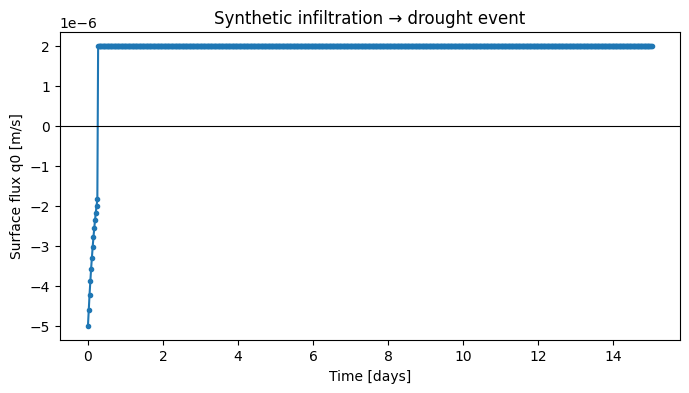

In [5]:
import numpy as np

def create_qflux_event(total_days=10, dt_minutes=30,
                       infil_peak=-5e-6, infil_duration_hours=6,
                       evap_rate=2e-6):
 
 
    dt_days = dt_minutes / (24*60)
    times = np.arange(0, total_days+dt_days, dt_days)

    # Rain/infiltration event at the start
    infil_duration_days = infil_duration_hours / 24.0
    qflux = np.full_like(times, evap_rate, dtype=float)

    mask = times <= infil_duration_days
    # Shape infiltration event as a decaying exponential
    qflux[mask] = infil_peak * np.exp(-times[mask] / infil_duration_days)

    return times, qflux


# Example usage
times, qflux = create_qflux_event(total_days=15)
q0_data = (times.tolist(), qflux.tolist())

plt.figure(figsize=(8,4))
plt.plot(times, qflux, '-o', ms=3)
plt.axhline(0, color='k', lw=0.8)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [m/s]")
plt.title("Synthetic infiltration → drought event")
plt.show()


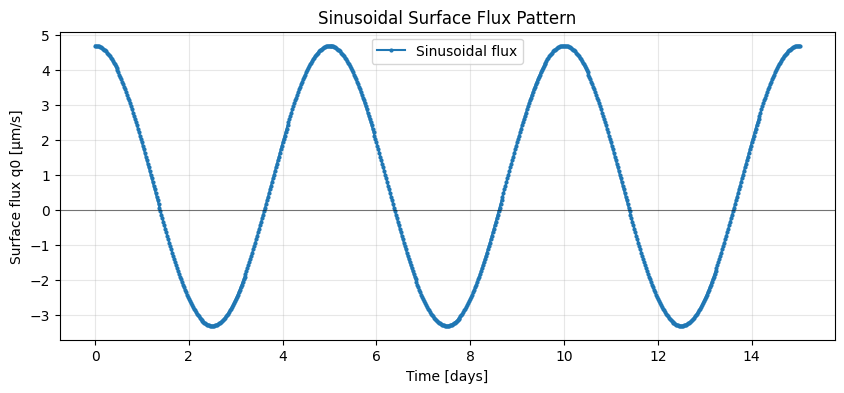

Flux range: -3.30 to 4.70 μm/s
Period: 5 days, Total duration: 15 days


In [6]:
def create_sinusoidal_qflux(total_days=15, dt_minutes=30,
                            amplitude=4e-6, period_days=5, 
                            mean_flux=1e-7, phase_shift=0):
    """
    Create sinusoidal surface flux pattern
    
    Parameters:
    - total_days: simulation duration
    - dt_minutes: time step in minutes
    - amplitude: amplitude of oscillation [m/s]
    - period_days: period of oscillation in days
    - mean_flux: mean flux level [m/s] (positive = evaporation, negative = infiltration)
    - phase_shift: phase shift in radians
    """
    dt_days = dt_minutes / (24*60)
    times = np.arange(0, total_days+dt_days, dt_days)
    
    # Sinusoidal flux: q(t) = mean + amplitude * sin(2π*t/period + phase)
    omega = 2 * np.pi / period_days  # angular frequency
    qflux = mean_flux + amplitude * np.sin(omega * times + phase_shift)
    
    return times, qflux

# Create sinusoidal q0_data
times_sin, qflux_sin = create_sinusoidal_qflux(
    total_days=15,
    amplitude=4e-6,      # 3 μm/s amplitude
    period_days=5,       # 5-day cycle
    mean_flux=7e-7,      # slight evaporation on average
    phase_shift=np.pi/2  # start at peak
)
qflux_sin = qflux_sin
q0_data_sin = (times_sin.tolist(), qflux_sin.tolist())

# Plot the sinusoidal flux
plt.figure(figsize=(10,4))
plt.plot(times_sin, qflux_sin*1e6, '-o', ms=2, label='Sinusoidal flux')
plt.axhline(0, color='k', lw=0.8, alpha=0.5)
plt.xlabel("Time [days]")
plt.ylabel("Surface flux q0 [μm/s]")
plt.title("Sinusoidal Surface Flux Pattern")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Flux range: {qflux_sin.min()*1e6:.2f} to {qflux_sin.max()*1e6:.2f} μm/s")
print(f"Period: {5} days, Total duration: {15} days")


In [ ]:

soil_params = {
    'theta_s': 0.4,
    'theta_r': 0.1,
    'alpha': 0.01,
    'n': 1.3,
    'Ks': 1e-5,
    'l': 0.5
}
# Define network configurations
h_net_config = {'hidden_dim': 64, 'num_layers': 4}
zb_net_config = {'hidden_dim': 32, 'num_layers': 3}

# Or specify custom initial depth
model, losses, comps = train_pinn_gradnorm(
    soil_params=soil_params,
    q0_data=q0_data_sin,
    Sy=0.1,
    zr=0.5,
    h_net_config=h_net_config,
    zb_net_config=zb_net_config,
    n_epochs=2000,
    learning_rate=1e-3,
    zb_initial=1.0  # 2m initial water table depth
)



Training for 2000 epochs | lr=0.001
Time domain from q0: t∈[0.000, 15.021], z adaptive in [-z_b(t), 0]
[   1/2000] total=2.710e-01 | PDE=9.648e-13, Surf=8.933e-11, WT(h)=6.582e-04, WT(kin)=3.117e-05, IC(h)=1.277e-01, IC(zb)=1.426e-01
{'pde': '9.648e-14', 'surf': '8.933e-11', 'wt_head': '6.582e-04', 'wt_kin': '3.117e-05', 'ic_h': '1.277e-01', 'ic_zb': '1.426e-01'}
[ 200/2000] total=1.305e+01 | PDE=8.537e-03, Surf=7.039e-02, WT(h)=3.467e-01, WT(kin)=6.475e-01, IC(h)=2.249e+00, IC(zb)=2.763e+00
{'pde': '1.267e-12', 'surf': '1.783e-10', 'wt_head': '5.345e-05', 'wt_kin': '5.869e-07', 'ic_h': '2.845e-04', 'ic_zb': '1.562e-05'}
[ 400/2000] total=9.764e+01 | PDE=9.094e+00, Surf=8.642e-01, WT(h)=9.637e-01, WT(kin)=6.871e-02, IC(h)=1.097e+00, IC(zb)=1.923e-04
{'pde': '3.928e-12', 'surf': '8.048e-12', 'wt_head': '4.578e-03', 'wt_kin': '5.531e-09', 'ic_h': '2.158e+00', 'ic_zb': '5.459e-10'}
[ 600/2000] total=9.480e+01 | PDE=2.908e+00, Surf=8.892e-01, WT(h)=1.728e+00, WT(kin)=1.374e-01, IC(h)=1.053

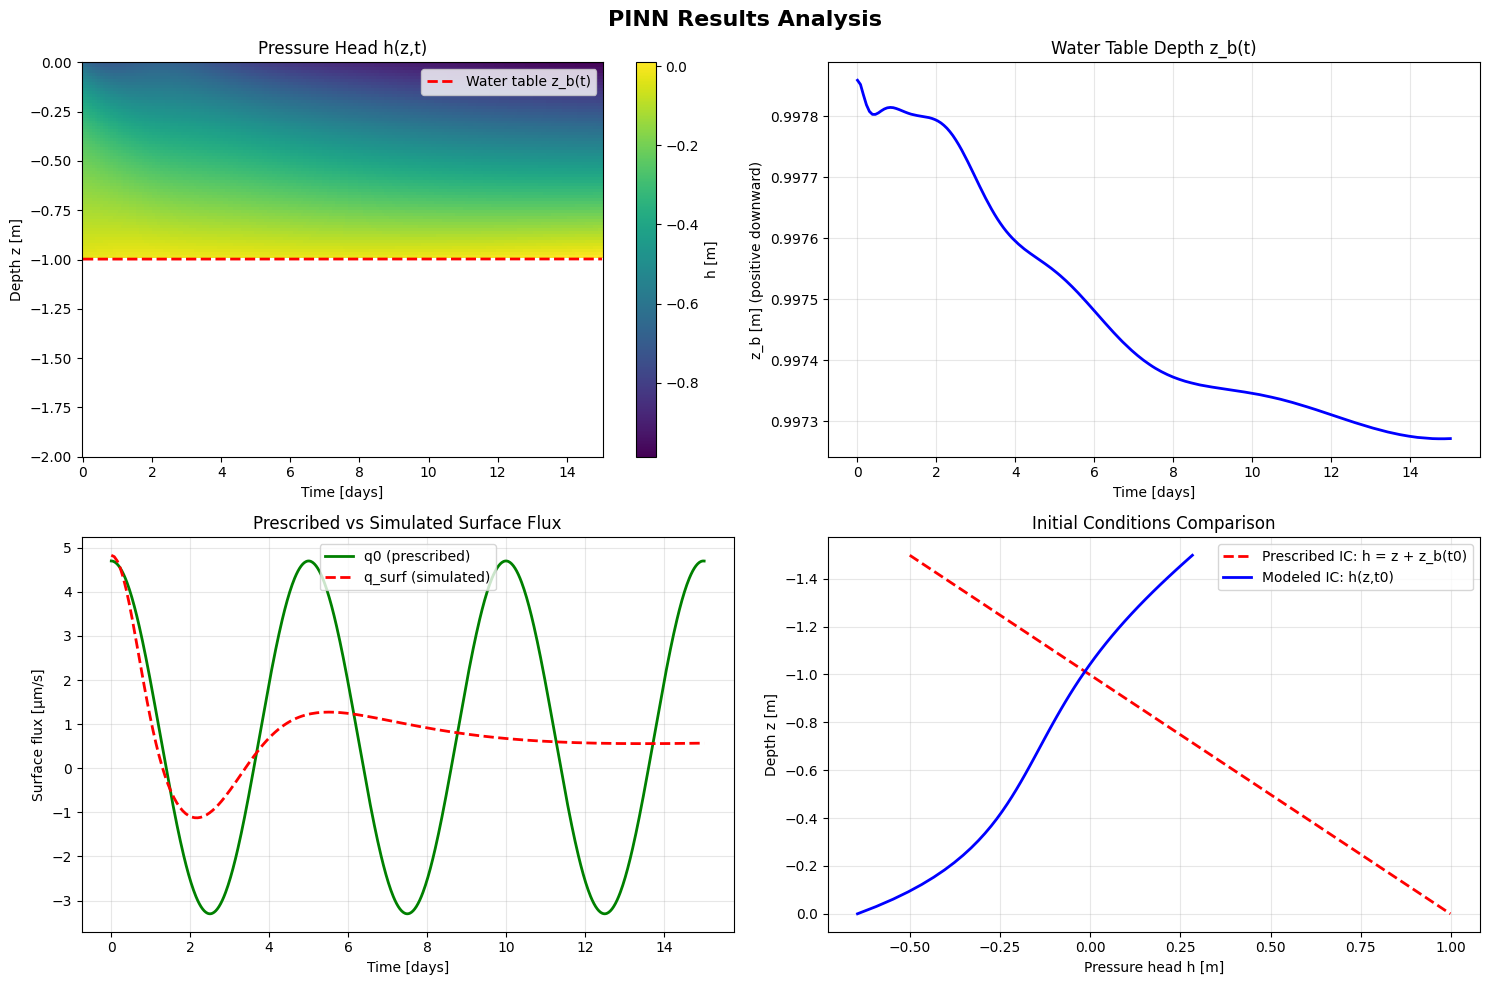


Summary Statistics:
Water table depth range: 0.997 to 0.998 m
Surface head range: -0.987 to -0.645 m
Max IC error: 1.642643 m


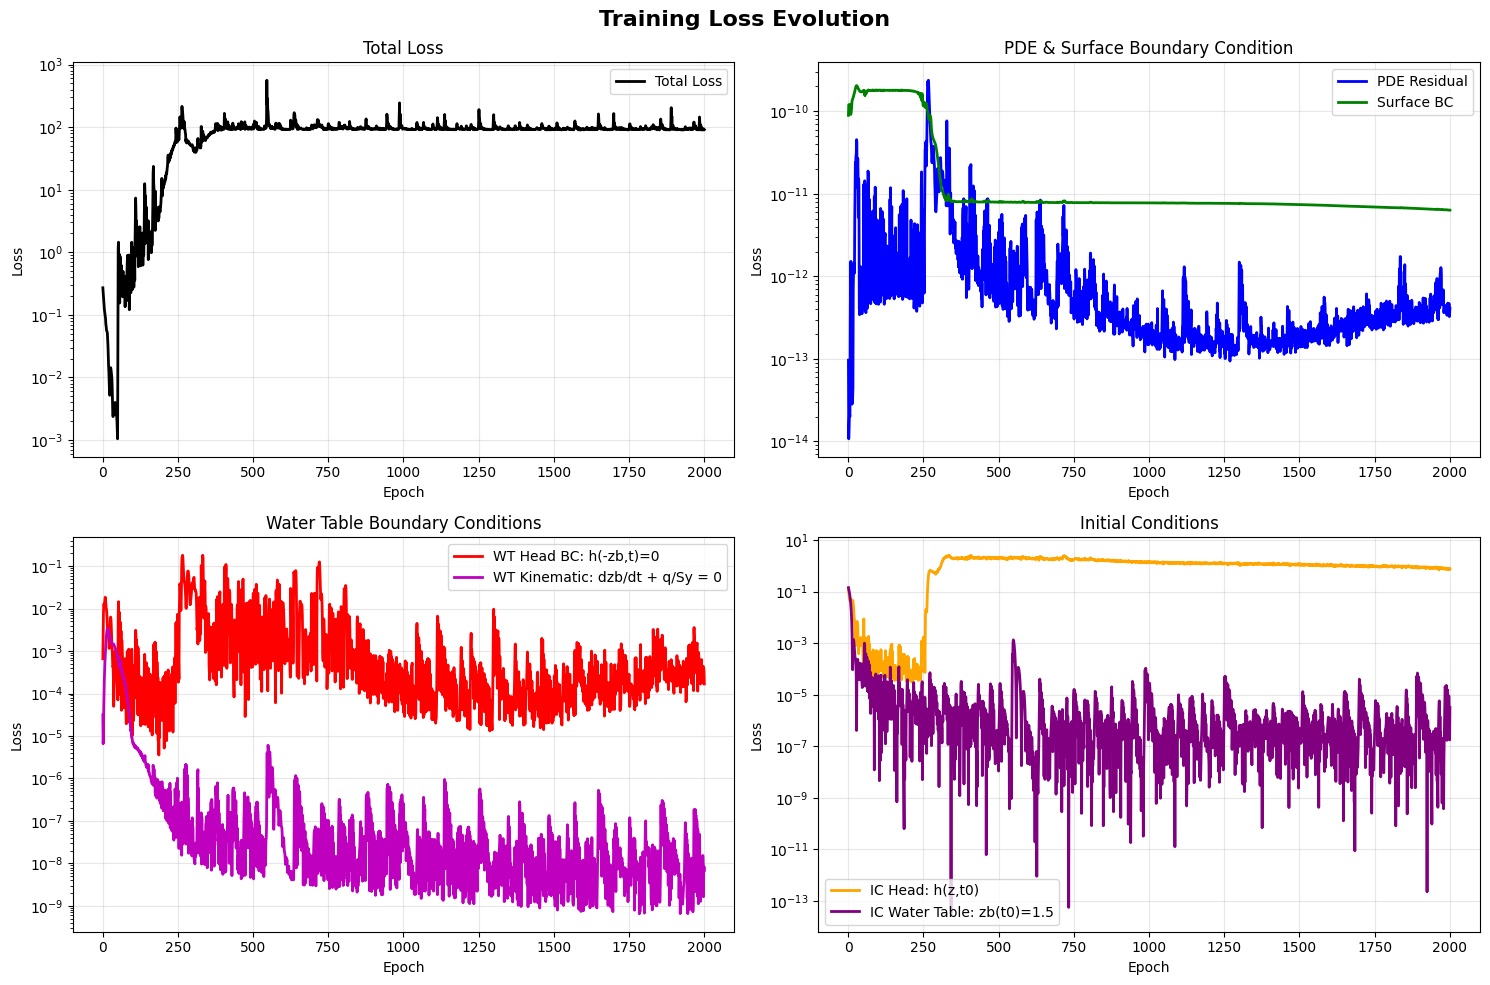


Final Loss Values (Epoch 2000):
Total Loss: 9.137532e+01
PDE Residual: 4.108334e-13
Surface BC: 6.347994e-12
WT Head BC: 1.681623e-04
WT Kinematic: 6.857200e-09
IC Head: 7.498068e-01
IC Water Table: 3.231210e-06


In [10]:
def plot_comprehensive_results(model, q0_data, soil_params, n_t=200, n_z=100):
    """
    Comprehensive plotting with 4 subplots:
    1. h(z,t) 2D colormap from -zb to 0
    2. zb(t) time series
    3. q0_data vs h(0,t) comparison
    4. Initial conditions: prescribed vs modeled
    """
    model.eval()
    
    # Get time range from q0_data
    t_min, t_max = min(q0_data[0]), max(q0_data[0])
    
    # Create time grid
    t_lin = torch.linspace(t_min, t_max, n_t).to(device)
    
    # Get water table depth over time
    with torch.no_grad():
        zb_vals = model.zb_net(t_lin.view(-1,1)).cpu().numpy().flatten()
    
    # Create adaptive z grid (from deepest water table to surface)
    z_min = -np.max(zb_vals) - 0.5  # Add some buffer
    z_max = 0.0
    z_lin = torch.linspace(z_min, z_max, n_z).to(device)
    
    # Create meshgrid for h(z,t)
    T, Z = torch.meshgrid(t_lin, z_lin, indexing="ij")
    t_flat = T.reshape(-1,1)
    z_flat = Z.reshape(-1,1)
    
    # Compute h(z,t) over the grid
    with torch.no_grad():
        h_flat, _ = model(z_flat, t_flat)
    H = h_flat.reshape(n_t, n_z).cpu().numpy()
    
    # Mask out regions below water table (physically meaningless)
    # Only show h(z,t) where z >= -zb(t) (i.e., above water table)
    T_np = T.cpu().numpy()
    Z_np = Z.cpu().numpy()
    
    H_masked = H.copy()
    for i, t_val in enumerate(t_lin.cpu().numpy()):
        zb_at_t = zb_vals[i]  # water table depth at this time
        mask = Z_np[i, :] < -zb_at_t  # regions below water table
        H_masked[i, mask] = np.nan  # mask with NaN (appears as white/transparent)
    
    # Get surface head h(0,t)
    z_surface = torch.zeros(n_t, 1).to(device)
    t_surface = t_lin.view(-1,1)
    with torch.no_grad():
        h_surface, _ = model(z_surface, t_surface)
    h_surface = h_surface.cpu().numpy().flatten()
    
    # Initial conditions
    t_ic = torch.tensor([t_min]).to(device).view(-1,1)
    z_ic_range = torch.linspace(z_min, z_max, 50).to(device).view(-1,1)
    
    # Prescribed IC: h(z,t0) = z + zb(t0)
    with torch.no_grad():
        zb_ic = model.zb_net(t_ic).cpu().numpy().item()
    h_ic_prescribed = z_ic_range.cpu().numpy().flatten() + zb_ic
    
    # Modeled IC
    t_ic_expanded = t_ic.expand(50, 1)
    with torch.no_grad():
        h_ic_modeled, _ = model(z_ic_range, t_ic_expanded)
    h_ic_modeled = h_ic_modeled.cpu().numpy().flatten()
    
    # Create the 4-subplot figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PINN Results Analysis', fontsize=16, fontweight='bold')
    
    # Subplot 1: h(z,t) 2D colormap with water table overlay
    im1 = axs[0,0].pcolormesh(T.cpu().numpy(), Z.cpu().numpy(), H_masked, 
                              shading="auto", cmap="viridis")
    axs[0,0].plot(t_lin.cpu().numpy(), -zb_vals, "r--", lw=2, label="Water table z_b(t)")
    axs[0,0].set_title("Pressure Head h(z,t)")
    axs[0,0].set_xlabel("Time [days]")
    axs[0,0].set_ylabel("Depth z [m]")
    axs[0,0].set_ylim(-2, 0)  # Set explicit limits: surface (0) at top, -2m at bottom
    axs[0,0].legend()
    plt.colorbar(im1, ax=axs[0,0], label="h [m]")
    
    # Subplot 2: zb(t) time series
    axs[0,1].plot(t_lin.cpu().numpy(), zb_vals, "b-", lw=2)
    axs[0,1].set_title("Water Table Depth z_b(t)")
    axs[0,1].set_xlabel("Time [days]")
    axs[0,1].set_ylabel("z_b [m] (positive downward)")
    axs[0,1].grid(True, alpha=0.3)
    
    # Subplot 3: q0_data vs simulated surface flux comparison
    # Calculate simulated surface flux q_surf at z=0
    z_surf_req = torch.zeros(n_t, 1, requires_grad=True).to(device)
    t_surf_req = t_lin.view(-1,1).requires_grad_(True)
    
    # Calculate simulated surface flux with gradients
    h_surf_grad, _ = model(z_surf_req, t_surf_req)
    K_surf = model.soil.K(h_surf_grad)
    dh_dz_surf = torch.autograd.grad(h_surf_grad.sum(), z_surf_req, create_graph=True)[0]
    q_surf_simulated = -K_surf * (dh_dz_surf + 1.0)
    q_surf_simulated = q_surf_simulated.detach().cpu().numpy().flatten()
    
    # Plot both fluxes
    axs[1,0].plot(q0_data[0], np.array(q0_data[1])*1e6, "g-", lw=2, label="q0 (prescribed)")
    axs[1,0].plot(t_lin.cpu().numpy(), q_surf_simulated*1e6, "r--", lw=2, label="q_surf (simulated)")
    axs[1,0].set_xlabel("Time [days]")
    axs[1,0].set_ylabel("Surface flux [μm/s]")
    axs[1,0].set_title("Prescribed vs Simulated Surface Flux")
    axs[1,0].grid(True, alpha=0.3)
    axs[1,0].legend()
    
    # Subplot 4: Initial conditions comparison
    axs[1,1].plot(h_ic_prescribed, z_ic_range.cpu().numpy().flatten(), 
                  "r--", lw=2, label="Prescribed IC: h = z + z_b(t0)")
    axs[1,1].plot(h_ic_modeled, z_ic_range.cpu().numpy().flatten(), 
                  "b-", lw=2, label="Modeled IC: h(z,t0)")
    axs[1,1].set_title("Initial Conditions Comparison")
    axs[1,1].set_xlabel("Pressure head h [m]")
    axs[1,1].set_ylabel("Depth z [m]")
    axs[1,1].legend()
    axs[1,1].grid(True, alpha=0.3)
    axs[1,1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Print some summary statistics
    print("\nSummary Statistics:")
    print(f"Water table depth range: {zb_vals.min():.3f} to {zb_vals.max():.3f} m")
    print(f"Surface head range: {h_surface.min():.3f} to {h_surface.max():.3f} m")
    print(f"Max IC error: {np.max(np.abs(h_ic_modeled - h_ic_prescribed)):.6f} m")

# Plot the comprehensive results
plot_comprehensive_results(model, q0_data_sin, soil_params)


def plot_training_losses(losses, comps, log_scale=True):
    """
    Plot detailed training loss evolution with all components
    
    Args:
        losses: list of total losses during training
        comps: dict with loss components ('pde', 'surf', 'wt_head', 'wt_kin', 'ic_h', 'ic_zb')
        log_scale: whether to use log scale for y-axis
    """
    epochs = range(1, len(losses) + 1)
    
    # Create figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Loss Evolution', fontsize=16, fontweight='bold')
    
    # Subplot 1: Total loss
    axs[0,0].plot(epochs, losses, 'k-', lw=2, label='Total Loss')
    axs[0,0].set_title('Total Loss')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Loss')
    if log_scale:
        axs[0,0].set_yscale('log')
    axs[0,0].grid(True, alpha=0.3)
    axs[0,0].legend()
    
    # Subplot 2: PDE and Surface BC losses
    axs[0,1].plot(epochs, comps['pde'], 'b-', lw=2, label='PDE Residual')
    axs[0,1].plot(epochs, comps['surf'], 'g-', lw=2, label='Surface BC')
    axs[0,1].set_title('PDE & Surface Boundary Condition')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Loss')
    if log_scale:
        axs[0,1].set_yscale('log')
    axs[0,1].grid(True, alpha=0.3)
    axs[0,1].legend()
    
    # Subplot 3: Water table losses
    axs[1,0].plot(epochs, comps['wt_head'], 'r-', lw=2, label='WT Head BC: h(-zb,t)=0')
    axs[1,0].plot(epochs, comps['wt_kin'], 'm-', lw=2, label='WT Kinematic: dzb/dt + q/Sy = 0')
    axs[1,0].set_title('Water Table Boundary Conditions')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Loss')
    if log_scale:
        axs[1,0].set_yscale('log')
    axs[1,0].grid(True, alpha=0.3)
    axs[1,0].legend()
    
    # Subplot 4: Initial condition losses
    axs[1,1].plot(epochs, comps['ic_h'], 'orange', lw=2, label='IC Head: h(z,t0)')
    axs[1,1].plot(epochs, comps['ic_zb'], 'purple', lw=2, label='IC Water Table: zb(t0)=1.5')
    axs[1,1].set_title('Initial Conditions')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Loss')
    if log_scale:
        axs[1,1].set_yscale('log')
    axs[1,1].grid(True, alpha=0.3)
    axs[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final loss values
    print(f"\nFinal Loss Values (Epoch {len(losses)}):")
    print(f"Total Loss: {losses[-1]:.6e}")
    print(f"PDE Residual: {comps['pde'][-1]:.6e}")
    print(f"Surface BC: {comps['surf'][-1]:.6e}")
    print(f"WT Head BC: {comps['wt_head'][-1]:.6e}")
    print(f"WT Kinematic: {comps['wt_kin'][-1]:.6e}")
    print(f"IC Head: {comps['ic_h'][-1]:.6e}")
    print(f"IC Water Table: {comps['ic_zb'][-1]:.6e}")

# Plot the training losses
plot_training_losses(losses, comps, log_scale=True)

